In [1]:
using Pkg
Pkg.add("Interpolations")
Pkg.add("BasicInterpolators")
Pkg.add("FFMPEG")

    Updating registry at `C:\Users\Miguel\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\Miguel\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Miguel\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Miguel\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Miguel\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Miguel\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Miguel\.julia\environments\v1.9\Manifest.toml`



# We solve for stratified atmosphere
Given that $\vec{q}=\nabla(\tau)$ and $\vec{w}$ is the wind velocity vector, for a stratified atmosphere we obtain $$\dfrac{dq_x}{dt}=\dfrac{dq_y}{dt}=0;\dfrac{dq_z}{dt}=-q\dfrac{\partial c}{\partial z}-\vec{q}.\dfrac{\partial \vec{w}}{\partial z}$$ (Brouwer 2014). We implement a case of sound speed dependent on height with temperature: $$c_{air}=331 \dfrac{m}{s}\sqrt{\dfrac{T_{z=0m}-\dfrac{z}{300m}}{273.15 K}}$$ and a diagonal wind $$\vec{w_{z=1m}}=(5,5)$$ at 1 m height that varies with height following a Logarithmic model $$\vec{w}=\vec{w_{z=1m}}(1+ln(\dfrac{z}{1m})) \hspace{0.5cm}if \hspace{0.1cm} z\geq 1 $$ 

We obtain: $$\dfrac{dq_z}{dz}=\dfrac{331^2\sqrt{q_{x}^2+q_{y}^2+q_z^2}q_z}{600*273.15*c(T,z)}-\dfrac{5(q_x+q_y)q_z}{z}$$

With $\dfrac{dt}{d\tau}=1$ and the initial condition $\tau(x,y,z=Source)=0$ we obtain $\tau=| \int \vec{q} d \vec{s} | \approx \Sigma |\vec{q_i}.\vec{\Delta {s_i}}  |  $ being s each differential element of the path traveled by the acoustic ray.

In [1]:
function v_wind_LogLaw(v_wind,z) # Wind profile
    v_wind_X=v_wind[1]*(1+log(z))
    v_wind_Y=v_wind[2]*(1+log(z))
    return v_wind_X, v_wind_Y
end
function c_air_TZ(T_z0,z)
    c_air=331*sqrt((T_z0+273.15-z/300)/273.15) # T_Z0 is entered in Celsius for convenience
    return c_air
end

c_air_TZ (generic function with 1 method)

We solve the ODE system: $\dfrac{dq_x}{dx}=\dfrac{dq_y}{dy}=0 ; \dfrac{dq_z}{dz}=\dfrac{331^2\sqrt{q_{x}^2+q_{y}^2+q_z^2}q_z}{600*273.15*c(T,z)}-\dfrac{5(q_x+q_y)q_z}{z}$

In [2]:
@time begin
using DifferentialEquations
#Arguments and data
T=15.;
v_wind=[5.,5.,0.];

SourcePoint=[1.,1.,1.];
# The logarithmic wind model is reasonable up to not very high altitudes.
ReceiverPoint=[5001.,5001.,501.];

# We define the ODE system
function q!(dq, q, p, z)
    c=c_air_TZ(p[1],z)
    dq[1]=0
    dq[2]=0
    dq[3] = 331^2*sqrt(q[1]^2 + q[2]^2 + q[3]^2)*q[3] / (600 * 273.15 *c) - 5*(q[1]+q[2])*q[3]/z
end
theta=rad2deg(acos(500/sqrt(2*5000^2+500^2)))
phi=45 # Calculated both directly.
# We define the initial conditions and parameters.
q0=1/(c_air_TZ(T, SourcePoint[3])+(v_wind[1]*cosd(phi)+v_wind[2]*sind(phi))*sind(theta))
q_x = q0*cosd(phi)*sind(theta)
q_y = q0*sind(phi)*sind(theta)
q_z = q0*cosd(theta)
u0 = [q_x, q_y, q_z]


# We define the range of z values. We must be careful when optimizing, given
# that if any optimized value (z coordinate) is outside of zspan we cannot evaluate it.
zspan = (SourcePoint[3], ReceiverPoint[3])

# We define the parameters.
p = [T] 

# We define the ODE problem.
prob = ODEProblem(q!, u0, zspan, p)

# We solve the ODE problem storing in the Z values that correspond to the intersections of the segments.
sol = solve(prob, RK4(),dt=1e-3)

# We save the values of vec(q).
qx_vals=zeros(length(sol.u))
qy_vals=zeros(length(sol.u))
qz_vals=zeros(length(sol.u))

for i in 1:length(sol.u)
    qx_vals[i]=sol.u[i][1]
    qy_vals[i]=sol.u[i][2]
    qz_vals[i]=sol.u[i][3]
end
#########################
end

 26.312198 seconds (24.28 M allocations: 1.703 GiB, 4.84% gc time, 14.51% compilation time: 1% of which was recompilation)


In [3]:
#Interpolate
using Interpolations
###### qx and qy are constants
qx=sum(qx_vals)/length(qx_vals)
######
qy=sum(qy_vals)/length(qy_vals)
######
# We interpolate to obtain qz(z) in every z between the source and the receiver
z_values_linear = collect(range(SourcePoint[3], stop=ReceiverPoint[3], length=length(qz_vals)))
qz_z_linear=LinearInterpolation(z_values_linear, qz_vals);

In [4]:
using DifferentialEquations

function Hamiltonian_l(qx::Float64,qy::Float64,qz_z_linear, SegmentsCoords::Array{Float64, 2})
   
    # We calculate the traveltime between each segment taking the average of the q's between each segment 
    #(Trapezoid rule approximation)
    taus=zeros(length(SegmentsCoords[:,1])-1)
    for i in 1:(length(SegmentsCoords[:,1])-1)
        # qx and qy are constants, it doesn't matter which element of the vector we take.
        aux_x=(SegmentsCoords[i+1,1]-SegmentsCoords[i,1])
        aux_y=(SegmentsCoords[i+1,2]-SegmentsCoords[i,2])
        #The interpolation function can extrapolate slightly outside the data range.
        #We must use  clamp() to ensure it interpolates within the range.
        z1 = clamp(SegmentsCoords[i,3], SegmentsCoords[1,3], SegmentsCoords[end,3])
        z2 = clamp(SegmentsCoords[i+1,3], SegmentsCoords[1,3], SegmentsCoords[end,3])
        aux_z=(SegmentsCoords[i+1,3]-SegmentsCoords[i,3])
        q_m=sqrt(qx^2+qy^2+(qz_z_linear(z1)+qz_z_linear(z2))^2/4)
        taus[i]=q_m*sqrt(aux_x^2+aux_y^2+aux_z^2)
    end
    
    # We add up the traveltime of each segment to get the total.
    total_travel_time = sum(taus)
        
    return total_travel_time
end

Hamiltonian_l (generic function with 1 method)

# Note

We see that qz decreases quite a bit as the height increases. It is reasonable for the optimizer to then concentrate the greatest number of points around the receiver. This is not realistic for the representation of a curve. Therefore, a penalty will be imposed if the points are not evenly spaced.

In [9]:
@time begin
using Optim
using Statistics
    
    
# We optimize the coordinates of the intersections between segments.
function objective(SegmentsCoords)
    # First, we make sure that SourcePoint and ReceiverPoint are not optimized but are included in SegmentsCoords
    FullSegmentsCoords = vcat(reshape(SourcePoint, 1, :), SegmentsCoords, reshape(ReceiverPoint, 1, :))
    traveltime = Hamiltonian_l(qx, qy, qz_z_linear, FullSegmentsCoords)

    # We calculate the distances between consecutive segments
    segment_distances = diff(FullSegmentsCoords, dims=1)

    # We calculate the standard deviation of the distances
    distance_std_normalized = Statistics.std(segment_distances)/(ReceiverPoint[3]-SourcePoint[3])

    # We add a penalty to the objective function based on the standard deviation of the distances
    return traveltime + distance_std_normalized
end


# Piecewise straight line from the source to the receiver as initial condition.
num_segments=10;
initial_SegmentsCoords = zeros(num_segments-1, 3); 
for i in 1:num_segments-1
    alpha = i / num_segments
    initial_SegmentsCoords[i, :] = SourcePoint + alpha * (ReceiverPoint - SourcePoint) 
end
# We have to take "box" constraints so that the optimized z values (SegmentsCoords[:,3]) 
# are not outside the solution interval (zspan)
lower_bounds = fill(SourcePoint[1], size(initial_SegmentsCoords))
upper_bounds = fill(ReceiverPoint[1], size(initial_SegmentsCoords))
lower_bounds[:, 3] .= SourcePoint[3]
upper_bounds[:, 3] .= ReceiverPoint[3]


# Internal optimizer. Limited-memory Broyden-Fletcher-Goldfarb-Shanno
# which is a second-order optimization method valid for minimizing non-linear functions.
inner_optimizer = LBFGS()

#Optimizer with the "box" constraints.
optimizer_with_constraints = Fminbox(inner_optimizer)

# We optimize with the constraints
result = optimize(objective, lower_bounds, upper_bounds, initial_SegmentsCoords, optimizer_with_constraints)

# Result of the optimization
Optimal_SegmentsCoords = result.minimizer;
    
# We include the source and the receiver in the optimized coordinates
Full_Optimal_SegmentsCoords= vcat(reshape(SourcePoint, 1, :), Optimal_SegmentsCoords, reshape(ReceiverPoint, 1, :))
    
# We evaluate the traveltime for the optimized trajectory
traveltime =Hamiltonian_l(qx, qy, qz_z_linear, Full_Optimal_SegmentsCoords)
println("The total traveltime for the segmented trajectory is: ", traveltime, " seconds")
end

println("Iteraciones realizadas: ", result.iterations)
println("Evaluaciones de la función: ", result.f_calls)



The total travel time for the segmented trajectory is: 20.422410839422536 seconds
  0.590926 seconds (2.08 M allocations: 155.345 MiB, 17.65% gc time, 29.53% compilation time: 100% of which was recompilation)
Iteraciones realizadas: 2
Evaluaciones de la función: 2040


In [10]:
@time begin
using Optim
using Statistics
#Arguments and data
T=20.;
v_wind=[10.,0.];

SourcePoint=[1.,1.,1.];
ReceiverPoint=[5001.,5001.,501.];

#We optimize the coordinates of the intersections between segments.
function objective(SegmentsCoords)
    # First, we make sure that SourcePoint and ReceiverPoint are not optimized but are included in SegmentsCoords.
    FullSegmentsCoords = vcat(reshape(SourcePoint, 1, :), SegmentsCoords, reshape(ReceiverPoint, 1, :))
    traveltime = Hamiltonian_l(qx, qy, qz_z_linear, FullSegmentsCoords)

    # We calculate the distances between consecutive segments
    segment_distances = diff(FullSegmentsCoords, dims=1)

    # We calculate the standard deviation of the distances
    distance_std_normalized = Statistics.std(segment_distances)/(ReceiverPoint[3]-SourcePoint[3])

    # We add a penalty to the objective function based on the standard deviation of the distances
    return traveltime + distance_std_normalized
end

# We define a matrix of matrices Plot_Coords the size of the loop, or higher, to then plot the distance of the points to a line.
Plot_Coords = Matrix{Matrix{Float64}}(undef, 10, 1)

# We iterate the initial condition.
initial_SegmentsCoords = zeros(1, 3); #c.i.
for i in 1:6
    if i == 1
        initial_SegmentsCoords[1, :] = SourcePoint + (ReceiverPoint - SourcePoint) / 2
    end
        
    lower_bounds = fill(0., size(initial_SegmentsCoords))
    upper_bounds = fill(6000., size(initial_SegmentsCoords))
    lower_bounds[:, 3] .= SourcePoint[3]
    upper_bounds[:, 3] .= ReceiverPoint[3]

    inner_optimizer = LBFGS()
    optimizer_with_constraints = Fminbox(inner_optimizer)
    result = optimize(objective, lower_bounds, upper_bounds, initial_SegmentsCoords, optimizer_with_constraints)
    Optimal_SegmentsCoords = result.minimizer;
    Full_Optimal_SegmentsCoords= vcat(reshape(SourcePoint, 1, :), Optimal_SegmentsCoords, reshape(ReceiverPoint, 1, :))
        
    # We store the coordinates of the optimization including the source and the receiver for later plotting.
    Plot_Coords[i]=Full_Optimal_SegmentsCoords
    
    # We evaluate the traveltime for the different number of segments proposed.
    total_time = Hamiltonian_l(qx, qy, qz_z_linear, Full_Optimal_SegmentsCoords)
    println("Num segments: ", Int(size(Full_Optimal_SegmentsCoords, 1) - 1), ". Traveltime:", total_time, " s")
    println("Iteraciones realizadas: ", result.iterations, ". Evaluaciones de la función: ", result.f_calls)
        

    copy_Optimal_SegmentsCoords = zeros(2 * size(Optimal_SegmentsCoords, 1) + 1, 3)
    
    # We calculate copy_optimal_SegmentsCoords  
    for j in 1:2 * size(Optimal_SegmentsCoords, 1) + 1
        if j==1
            copy_Optimal_SegmentsCoords[j,:]=(SourcePoint+Optimal_SegmentsCoords[1,:])/2
        elseif j==2*size(Optimal_SegmentsCoords,1)+1
            copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[end,:]+ReceiverPoint)/2
        else
            if iseven(j)
                copy_Optimal_SegmentsCoords[j,:]=Optimal_SegmentsCoords[Int(j/2),:]
            else
                copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[Int((j-1)/2),:]+Optimal_SegmentsCoords[Int((j+1)/2),:])/2
            end
        end
    end
    # Here we iterate the initial condition.
    initial_SegmentsCoords = copy(copy_Optimal_SegmentsCoords)
end
end




Num segments: 2. Traveltime:20.42216689748531 s
Iteraciones realizadas: 1. Evaluaciones de la función: 28
Num segments: 4. Traveltime:20.422354353649837 s
Iteraciones realizadas: 1. Evaluaciones de la función: 71
Num segments: 8. Traveltime:20.42241162756099 s
Iteraciones realizadas: 1. Evaluaciones de la función: 478
Num segments: 16. Traveltime:20.4224141936285 s
Iteraciones realizadas: 1. Evaluaciones de la función: 3659
Num segments: 32. Traveltime:20.422415331048786 s
Iteraciones realizadas: 1. Evaluaciones de la función: 1315
Num segments: 64. Traveltime:20.42241541269233 s
Iteraciones realizadas: 2. Evaluaciones de la función: 1729
  9.014721 seconds (22.13 M allocations: 4.569 GiB, 10.67% gc time, 1.97% compilation time: 100% of which was recompilation)


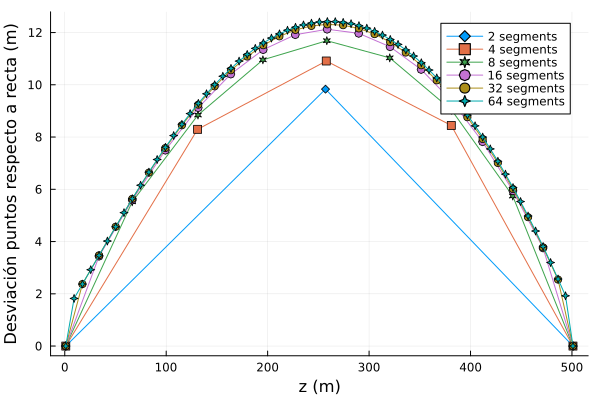

In [7]:
using Plots 

# We define the names of the labels and shapes for each number of segments
labels = ["2 segments", "4 segments", "8 segments", "16 segments", "32 segments", "64 segments", "128 segments", "256 segments", "512 segments"]
shapes = [:diamond, :square, :star6, :octagon, :circle, :star4, :star5, :octagon, :circle]

plot()

# We iterate over each set of segment coordinates
for i in 1:6
    z = Plot_Coords[i][:, 3]
    aux = sqrt.((Plot_Coords[i][:, 1]/10-Plot_Coords[i][:, 3]).^2+(Plot_Coords[i][:, 2]/10-Plot_Coords[i][:, 3]).^2)
    aux[1] = aux[end] = 0.
    plot!(z, aux, label=labels[i], shape=shapes[i])
end

xlabel!("z (m)")
ylabel!("Deviation to a straight line (m)")
#savefig("name.png")

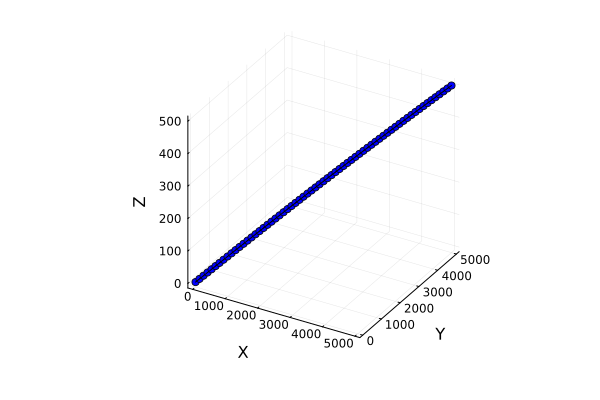

In [8]:
#Trajectory
using Plots
plot()

x_coords = Plot_Coords[6][:, 1]
y_coords = Plot_Coords[6][:, 2]
z_coords = Plot_Coords[6][:, 3]

scatter!(x_coords, y_coords, z_coords, marker=:circle, color=:blue, legend=false)
for i in 1:length(x_coords)-1
    plot!([x_coords[i], x_coords[i+1]], [y_coords[i], y_coords[i+1]], [z_coords[i], z_coords[i+1]], color=:black, linewidth=1)
end

xlabel!("X")
ylabel!("Y")
zlabel!("Z")

[ Info: Saved animation to C:\Users\Miguel\Desktop\TFM\Codigos Julia\CurveEvolution.gif


Plots.AnimatedGif("C:\\Users\\Miguel\\Desktop\\TFM\\Codigos Julia\\CurveEvolution.gif")
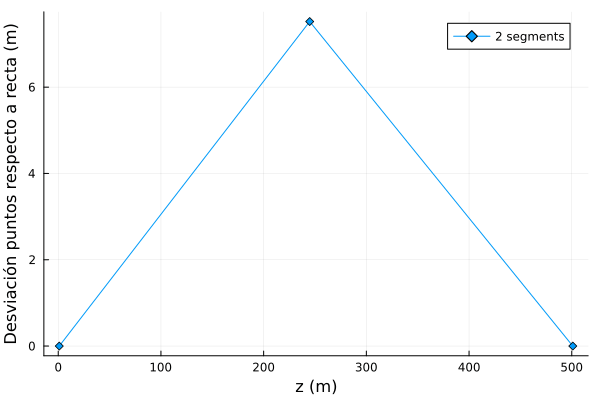

In [14]:
#Gif
using Plots
using FFMPEG

# We define the label names and shapes for each number of segments
labels = ["2 segments", "4 segments", "8 segments", "16 segments", "32 segments", "64 segments", "128 segments", "256 segments", "512 segments"]
shapes = [:diamond, :square, :star6, :octagon, :circle, :star4, :star5, :octagon, :circle]

# We create an array to store each frame of the GIF
frames = []

# We iterate over each set of segment coordinates
for i in 1:6
    z = Plot_Coords[i][:, 3]
    aux = sqrt.((Plot_Coords[i][:, 1]/10-Plot_Coords[i][:, 3]).^2+(Plot_Coords[i][:, 2]/10-Plot_Coords[i][:, 3]).^2)
    aux[1] = aux[end] = 0.
    
    # We create the plot and add it to the GIF frames
    p = plot(z, aux, label=labels[i], shape=shapes[i])
    xlabel!(p, "z (m)")
    ylabel!(p, "Desviación puntos respecto a recta (m)")
    push!(frames, p)
end

# We create the GIF from the frames
anim = @animate for i=1:length(frames)
    plot(frames[i])
end

# We save the GIF
#gif(anim,"CurveEvolution.gif",fps=0.5)
